In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/work/ka1176/paul/PCA_tropical_temp/notebooks'

In [91]:
import xarray as xr
import sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
sys.path.append("../src/")
import utils
import neural_nets
import datasets

In [20]:
var="t"
level=300
PCA_xr = xr.open_dataset("../data/PCAs/era5_{var}_{level}_PCA.nc")
PC_time_series = PCA_xr.time_series

In [266]:
PCA_xr.PCAs

<xarray.Dataset>
Dimensions:             (PCAs: 5, values: 181760, time: 996)
Coordinates:
  * PCAs                (PCAs) int64 1 2 3 4 5
  * values              (values) int64 0 1 2 3 4 ... 181756 181757 181758 181759
  * time                (time) datetime64[ns] 1940-01-01T12:00:00 ... 2022-12...
Data variables:
    components          (PCAs, values) float32 ...
    time_series         (time, PCAs) float32 -576.7 240.0 ... -124.8 -96.65
    explained_variance  (PCAs) float32 ...

In [7]:
predictors = xr.open_mfdataset("../data/era5/E5pl00_1M_????_130_lt_global_5.nc")
predictors["q"] = xr.open_mfdataset("../data/era5/E5pl00_1M_????_133_lt_global_5.nc").q
predictors["sst"] = xr.open_mfdataset("../data/era5/E5sf00_1M_????_034_global_5.nc").sst

predictors.coords["plev2"] = predictors.isobaricInhPa
predictors = predictors.swap_dims({"isobaricInhPa": "plev2"})

In [8]:
predictors["MSE"] = utils.xr_MSE(predictors.t,predictors.q)

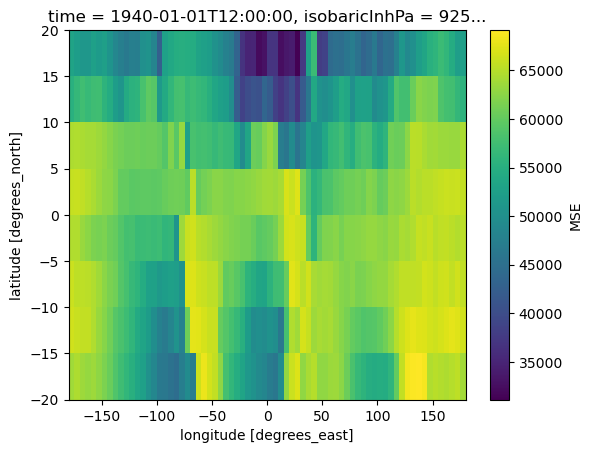

In [9]:
predictors.MSE.isel(time=0).sel(plev2=925, lat=slice(-20,20)).plot(x="lon",y="lat")

In [49]:
predictors_norm, predictors_mean, predictors_std = utils.normalise(predictors)
PC_norm, PC_mean, PC_std = utils.normalise(PC_time_series)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [50]:
MSE_925 = predictors_norm.MSE.sel(plev2=925.0,lat= slice(-20,20)).stack(coord=["lon","lat"])

In [145]:
MSE_925_train = MSE_925.isel(time=slice(0,800))
MSE_925_test = MSE_925.isel(time=slice(800,996))
PC_train = PC_norm.isel(time=slice(0,800))
PC_test = PC_norm.isel(time=slice(800,996))

In [60]:
trainset = datasets.SimpleDataset(MSE_925_train.values, PC_train.values)
testset = datasets.SimpleDataset(MSE_925_test.values, PC_test.values)

In [61]:
batch_size = 16

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [349]:
epochs = 100
learning_rate = 1e-3
weight_decay = 2e-2 # at 1e-1 things start getting worse, 1e-3 is too small, too much overfitting
hidden_layers = [64, 32, 16] 
dropout = 0.5

loss_function = torch.nn.MSELoss()
model = neural_nets.SimpleNeuralNet(MSE_925_train.values.shape[1], PC_train.values.shape[1], hl=hidden_layers, dropout=dropout)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay = weight_decay)

In [350]:
losses, test_losses = utils.trainer(epochs, train_dataloader, test_dataloader, model, optimizer, loss_function)

Epochs: 0/100
Training Loss : 0.7814697027206421
Validation Loss : 0.8110851645469666
Epochs: 10/100
Training Loss : 0.3017760217189789
Validation Loss : 0.3749534487724304
Epochs: 20/100
Training Loss : 0.2877471446990967
Validation Loss : 0.36287131905555725
Epochs: 30/100
Training Loss : 0.2816506326198578
Validation Loss : 0.3499396741390228
Epochs: 40/100
Training Loss : 0.27624720335006714
Validation Loss : 0.34972360730171204
Epochs: 50/100
Training Loss : 0.26335835456848145
Validation Loss : 0.34689992666244507
Epochs: 60/100
Training Loss : 0.27832406759262085
Validation Loss : 0.3752616345882416
Epochs: 70/100
Training Loss : 0.280834436416626
Validation Loss : 0.36817190051078796
Epochs: 80/100
Training Loss : 0.272334486246109
Validation Loss : 0.3594715893268585
Epochs: 90/100
Training Loss : 0.26438552141189575
Validation Loss : 0.35437631607055664


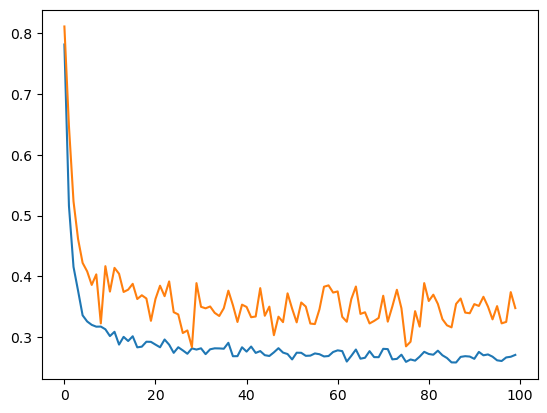

In [351]:
plt.plot(losses)
plt.plot(test_losses)

In [352]:
model.eval()
test_pred = (model(testset.X).detach().numpy() * PC_std.values) + PC_mean.values
test = (PC_test * PC_std.values) + PC_mean.values

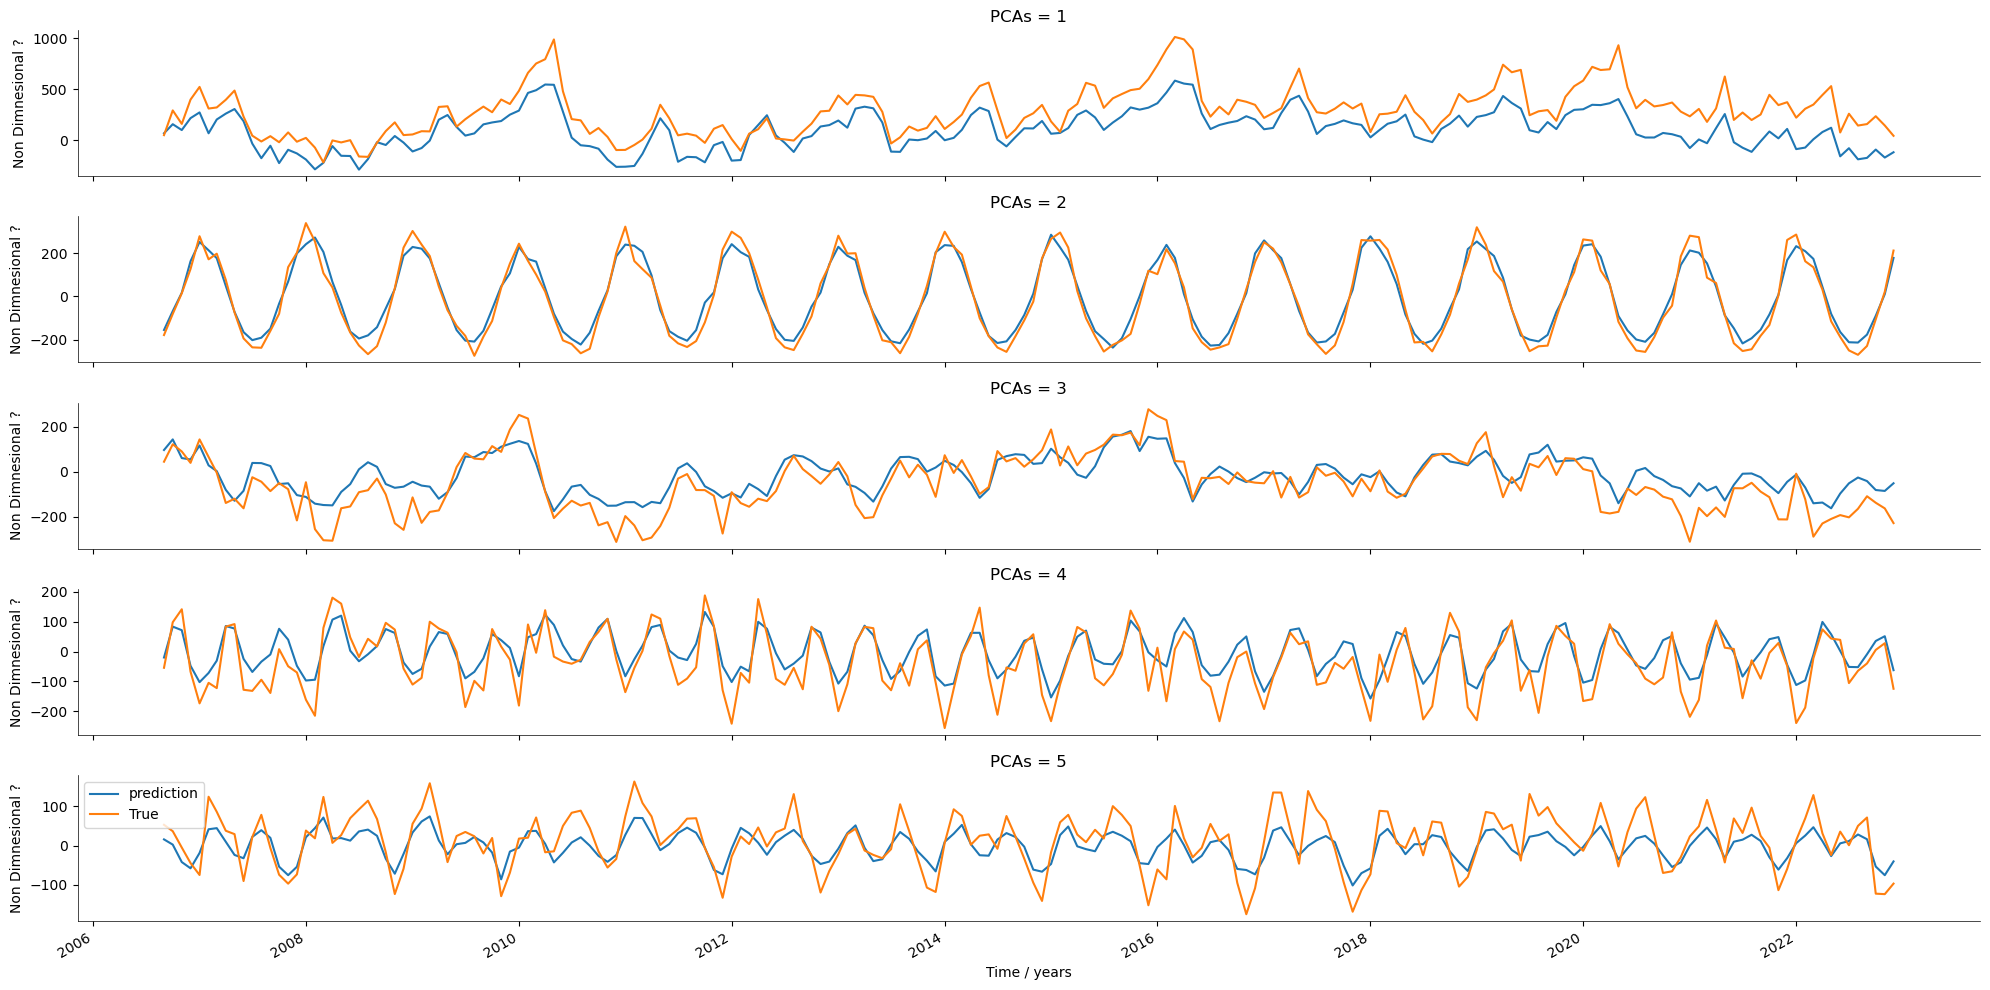

In [353]:
fig,xs = plt.subplots(len(PC_mean.values),1,figsize=(20,10), sharex=True)

for i in range(len(PC_mean.values)) :
    ax=xs[i]
    ax.plot(PC_test.time, test_pred[:,i], label="prediction")
    test.sel(PCAs=i +1).plot(x="time",ax=ax, label="True")
    ax.set_xlabel("")
    ax.set_ylabel("Non Dimnesional ?")
    utils.remove_axes(ax)
ax.set_xlabel("Time / years")
ax.legend()
fig.tight_layout()


In [354]:
attrs = xr.DataArray(coords = [MSE_925_test.coord, MSE_925_test.time,PCA_xr.PCAs])

In [355]:
from captum.attr import IntegratedGradients
model.eval()
ig = IntegratedGradients(model)
for i in range(5) :
    a, delta = ig.attribute(testset.X, target = i, return_convergence_delta=True)
    attrs.loc[dict(PCAs=i+1)] = a.detach().numpy().T

In [356]:
MSE_925_test_attrs = xr.zeros_like(MSE_925_test)
MSE_925_test_attrs.data = attributions

In [357]:
MSE_925_test_unstack = attrs.unstack("coord")
MSE_925_test_unstack_mean = MSE_925_test_unstack.mean("time")

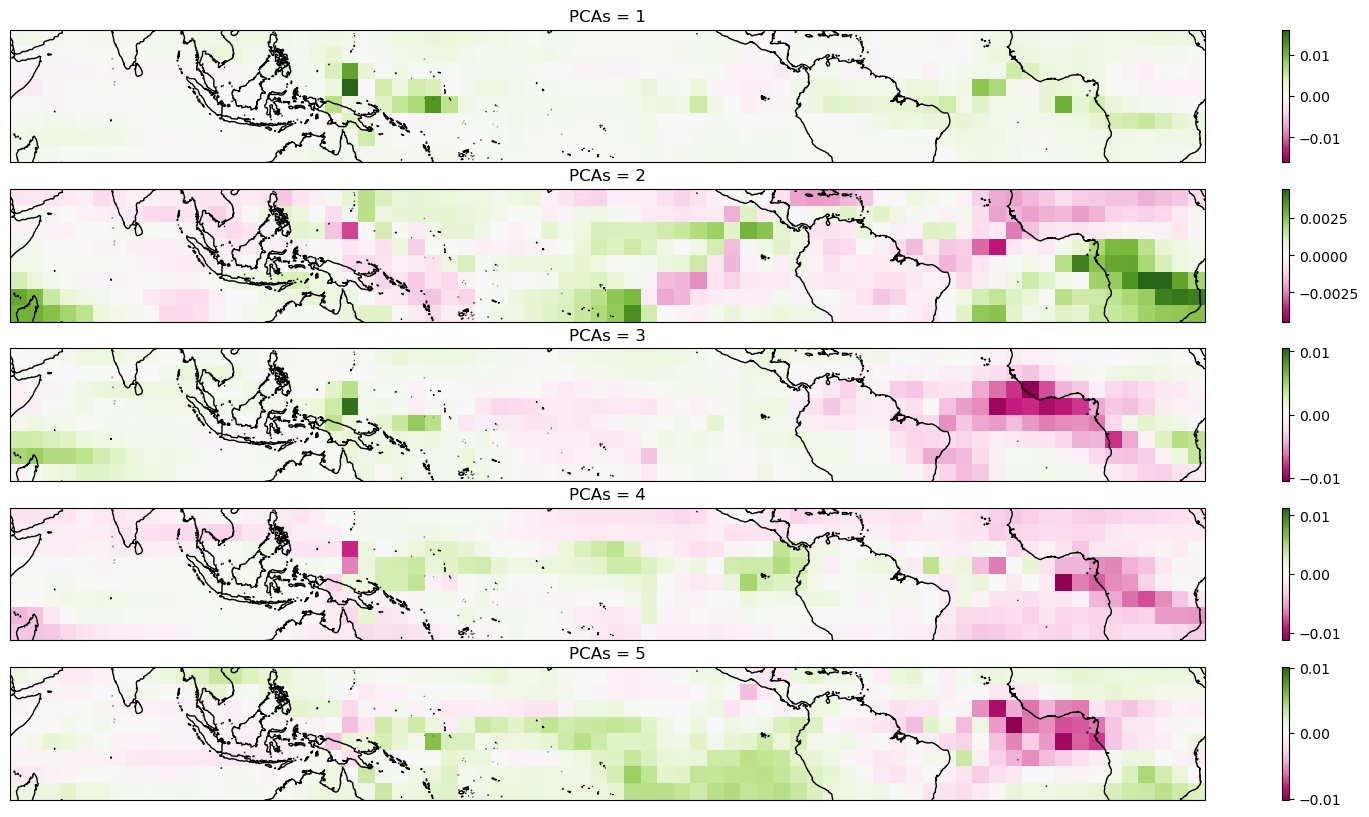

In [358]:
import cartopy.crs as ccrs

fig,xs = plt.subplots(5,1,figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

for i in range(5) :
    ax=xs[i]
    MSE_925_test_unstack_mean.sel(PCAs=i+1).plot(x="lon",y="lat",cmap='PiYG', ax = ax)
    utils.set_regional_cartopy(ax)
    